In [1]:
from manim import *
import jupyter_capture_output

video_scene = " -v WARNING --progress_bar None --disable_caching coriolis_Scene"
image_scene = f" -v WARNING --progress_bar None --disable_caching -r {2*427},{2*240}  -s coriolis_Scene"

Manim Community v0.17.3

Jupyter Capture Output v0.0.11


In [2]:
def rk4_step(t, delta_t, y_array, ode, params):
    k1 = np.zeros_like(y_array)
    k2 = np.zeros_like(y_array)
    k3 = np.zeros_like(y_array)
    k4 = np.zeros_like(y_array)
    support = np.zeros_like(y_array)
    ode(t, y_array, k1, params) 

    # Berechnung k1 = f(t, y) * dt und support = y + k1/2
    k1 = (k1 * delta_t)
    support = y_array + k1 / 2

    # Berechnung k2 = f(t+dt/2, y+k1/2) * dt und support = y + k2/2
    ode(t+delta_t/2, support, k2, params)
    k2 = (k2 * delta_t)
    support = y_array + k2 / 2

    # Berechnung k3 = f(t+dt/2, y+k2/2) * dt und support = y + k3
    ode(t+delta_t/2, support, k3, params)
    k3 = (k3 * delta_t)
    support = y_array + k3

    # Berechnung k4 = f(t+dt, y+k2) * dt und y_(i+1)
    ode(t+delta_t, support, k4, params)
    k4 = (k4 * delta_t)
    y_array = y_array + (k1 + 2*k2 + 2*k3 + k4) / 6
    return y_array + (k1 + 2*k2 + 2*k3 + k4) / 6

In [221]:
class PressureField(Mobject):
    def __init__(self, center = np.array([0, 0, 0]), low_center = np.array([-5, 0, 0]), high_center = np.array([5, 0, 0]), low = -5, high = 5, **kwargs):
        super().__init__(**kwargs)

        # coordinate system
        x_range = np.array([-10, 10, 1])
        y_range = np.array([-40, 40, 1])
        x_length = 20
        y_length = 20
        self.x_scale = (x_range[1] - x_range[0]) / x_length
        self.y_scale = (y_range[1] - y_range[0]) / y_length
        self.npla = NumberPlane(
            x_range = x_range, y_range = y_range, x_length = x_length, y_length = y_length,
            x_axis_config = {"stroke_opacity": 0.215, "stroke_color": BLACK}, y_axis_config = {"stroke_opacity": 0.125, "stroke_color": BLACK}, background_line_style = {"stroke_opacity": 0.125}).move_to(center)
        self.add(self.npla)

        # parameters
        self.low_center_OG = low_center
        self.high_center_OG = high_center
        self.low_center = self.npla.c2p(*low_center)
        self.high_center = self.npla.c2p(*high_center)
        self.low = low
        self.high = high

        low_L = Text('L', color = BLUE).move_to(self.low_center)
        high_H = Text('H', color = RED).move_to(self.high_center)
        self.add(high_H, low_L)

    
    # legend
    def get_legend(self, center, height = 2.25, width = 3.5, opacity = 0.9, friction_arrow = False):
        legend_bg = Rectangle(height = height, width = width, stroke_color = WHITE, stroke_opacity = opacity, fill_opacity = opacity).move_to(center)
        legend_bg.z_index = 0.5
        
        legend_group = VGroup(legend_bg)
        if friction_arrow:
            friction = 1
            font_size = 48
            arrow_friction_force = Line(start = center - 0.25*UP + 1.5*LEFT, end = center - 0.25*UP + 0.75*LEFT, stroke_width = 3, color = RED).add_tip(tip_width = 0.2, tip_length = 0.2)
            arrow_friction_force.z_index = 2
            arrow_friction_force.tip.z_index = 2
            text_friction_force = MathTex(r"\Vec{F}_\mathrm{Friction}=-\gamma\cdot\Vec{v}", color = RED, font_size = font_size).next_to(center - 0.25*UP + 0.5*LEFT, 0.75*RIGHT)
            for i in range(len(text_friction_force[0])):
                text_friction_force[0][i].z_index = 4
            legend_group.add(arrow_friction_force, text_friction_force)
        else:
            friction = 0
            font_size = 24
            
        arrow_grad_force = Line(start = center + 0.75*UP + 1.5*LEFT, end = center + 0.75*UP + 0.75*LEFT, stroke_width = 3, color = BLUE).add_tip(tip_width = 0.2, tip_length = 0.2)
        arrow_coriolis_force = Line(start = center + 0.25*friction*UP + 1.5*LEFT, end = center + 0.25*friction*UP + 0.75*LEFT, stroke_width = 3, color = GREY).add_tip(tip_width = 0.2, tip_length = 0.2)
        arrow_total_force = Line(start = center - 0.75*UP + 1.5*LEFT, end = center - 0.75*UP + 0.75*LEFT, stroke_width = 3, color = BLACK).add_tip(tip_width = 0.2, tip_length = 0.2)
        arrow_grad_force.z_index = 2
        arrow_coriolis_force.z_index = 2
        arrow_total_force.z_index = 2
        arrow_grad_force.tip.z_index = 2
        arrow_coriolis_force.tip.z_index = 2
        arrow_total_force.tip.z_index = 2

        text_grad_force = MathTex(r"\Vec{F}_\mathrm{Grad}=-\nabla P", color = BLUE, font_size = font_size).next_to(center + 0.75*UP + 0.5*LEFT, 0.75*RIGHT)
        text_coriolis_force = MathTex(r"\Vec{F}_\mathrm{Coriolis}\propto\Vec{\omega}\times\Vec{v}", color = GREY, font_size = font_size).next_to(center + 0.25*friction*UP + 0.5*LEFT, 0.75*RIGHT)
        text_total_force = MathTex(r"\Vec{F}_\mathrm{Total}", color = BLACK, font_size = font_size).next_to(center - 0.75*UP + 0.5*LEFT, 0.75*RIGHT)

        # whatever this shit is, it works and it only works like this
        for i in range(len(text_grad_force[0])):
            text_grad_force[0][i].z_index = 4
        for i in range(len(text_coriolis_force[0])):
            text_coriolis_force[0][i].z_index = 4
        for i in range(len(text_total_force[0])):
            text_total_force[0][i].z_index = 4

        legend_group.add(arrow_grad_force, arrow_coriolis_force, arrow_total_force, text_grad_force, text_coriolis_force, text_total_force)
        return legend_group
        

    # scalar funcion returning air prssure
    def pressure(self, offset = 0, npla_system = False):
        # which system to calculate the pressure in
        if npla_system:
            low_center = self.low_center
            high_center = self.high_center
            x_scale = self.x_scale
            y_scale = self.y_scale
        else:
            low_center = self.low_center_OG
            high_center = self.high_center_OG
            x_scale = 1
            y_scale = 1

        def parametric_pressure_function(x, y):
            smoothing_factor = 10e-8
            pressure_low = self.low / (np.sqrt(((x-low_center[0]) / x_scale)**2 + ((y-low_center[1]) / y_scale)**2) + smoothing_factor)
            pressure_high = self.high / (np.sqrt(((x-high_center[0]) / x_scale)**2 + ((y-high_center[1]) / y_scale)**2) + smoothing_factor)
            return pressure_low + pressure_high + offset
        return parametric_pressure_function
    

    # returns x isobars
    def get_isobars(self, isobaric_density = 10):
        isobar_group = VGroup()
        for i in range(0, isobaric_density+1):
            offset = self.low + i * (self.high - self.low) / isobaric_density
            isobar_low = ImplicitFunction(self.pressure(offset, npla_system = True), color = BLUE, stroke_width = 2, stroke_opacity = i/isobaric_density)
            isobar_high = ImplicitFunction(self.pressure(offset, npla_system = True), color = RED, stroke_width = 2, stroke_opacity = 1 - i/isobaric_density)
            isobar_group.add(isobar_low, isobar_high)
        return isobar_group
    

    # force from air pressure gradient
    def get_grad_force(self, air_state, params):
        pressure_function = self.pressure()
        dr = 0.00001
        x = air_state[0]
        y = air_state[1]
        f_grad_x = -(pressure_function(x+dr, y) - pressure_function(x-dr, y)) / (2*dr)
        f_grad_y = -(pressure_function(x, y+dr) - pressure_function(x, y-dr)) / (2*dr)
        print(f_grad_y)
        return np.array([f_grad_x, f_grad_y, 0])


    # coriolis force
    def get_coriolis_force(self, air_state, params):
        omega = params[1]
        latitude = params[2]
        v_x = air_state[2]
        v_y = air_state[3]
        f_coriolis_x = -omega * v_y * np.sin(latitude * 2*PI / 360)
        f_coriolis_y = omega * v_x * np.sin(latitude * 2*PI / 360)
        return np.array([f_coriolis_x, f_coriolis_y, 0])
    

    # force from fiction
    def get_friction_force(self, air_state, params):
        gamma = params[0]
        v_x = air_state[2]
        v_y = air_state[3]
        f_friction_x = -gamma * v_x
        f_friction_y = -gamma * v_y
        return np.array([f_friction_x, f_friction_y, 0])


    # ordinary differential equation for an air block in air_state with paramters (gamma, omega) for friction and earth rotation
    def get_ODE_Coriolis(self, t, air_state, f_air_state, params):
        # force from air pressure
        f_grad = self.get_grad_force(air_state, params)

        # coriolis force
        f_coriolis = self.get_coriolis_force(air_state, params)

        # force from friction
        f_friction = self.get_friction_force(air_state, params)

        # create derivation array for the air block
        f_air_state[0] = air_state[2]
        f_air_state[1] = air_state[3]
        f_air_state[2] = f_grad[0] + f_coriolis[0] + f_friction[0]
        f_air_state[3] = f_grad[1] + f_coriolis[1] + f_friction[1]
        return
    

    # builds block of air including arrows for forces
    def get_air_block(self, air_state, params, grad_arrow = True, coriolis_arrow = True, friction_arrow = False):
        air_block_group = VGroup()

        # arrow_parameters
        tip_width = 0.2
        tip_length = 0.2
        arrow_width = 3

        # air block
        air_pos = self.npla.c2p(air_state[0], air_state[1], 0)
        air_block = Square(side_length = 0.5, color = BLACK).move_to(air_pos)
        air_block_group.add(air_block)

        # arrow for gradient
        f_grad = self.get_grad_force(air_state, params)
        f_grad_arrow = Line(start = air_pos, end = air_pos+f_grad, stroke_width = arrow_width, color = BLUE).add_tip(tip_width = tip_width, tip_length = tip_length)
        if grad_arrow:
            air_block_group.add(f_grad_arrow)

        # arrow for coriolis force
        f_coriolis = self.get_coriolis_force(air_state, params)
        f_coriolis_arrow = Line(start = air_pos, end = air_pos+f_coriolis, stroke_width = arrow_width, color = GREY).add_tip(tip_width = tip_width, tip_length = tip_length)
        if coriolis_arrow:
            air_block_group.add(f_coriolis_arrow)

        # arrow for friction
        f_friction = self.get_friction_force(air_state, params)
        f_friction_arrow = Line(start = air_pos, end = air_pos+f_friction, stroke_width = arrow_width, color = RED).add_tip(tip_width = tip_width, tip_length = tip_length)
        if friction_arrow:
            air_block_group.add(f_friction_arrow)

        # arrow for final force
        f_total = f_grad + f_coriolis + f_friction
        f_total_arrow = Line(start = air_pos, end = air_pos+f_total, stroke_width = arrow_width, color = BLACK).add_tip(tip_width = tip_width, tip_length = tip_length)
        air_block_group.add(f_total_arrow)


        # print(f"f_grad: {f_grad}")
        # print(f"f_coriolis: {f_coriolis}")
        # print(f"f_total: {f_total}")

        # f_speed_arrow = Line(start = air_pos, end = air_pos+np.array([air_state[2], air_state[3], 0]), stroke_width = arrow_width, color = RED).add_tip(tip_width = tip_width, tip_length = tip_length)
        # f_speed_perp_arrow = Line(start = air_pos, end = air_pos+np.array([-air_state[3], air_state[2], 0]), stroke_width = arrow_width, color = ORANGE).add_tip(tip_width = tip_width, tip_length = tip_length)
        # air_block_group.add(f_speed_arrow, f_speed_perp_arrow)
        return air_block_group

Output saved by overwring previous file at animations/coriolis/coriolis_air.mp4.
-0.0


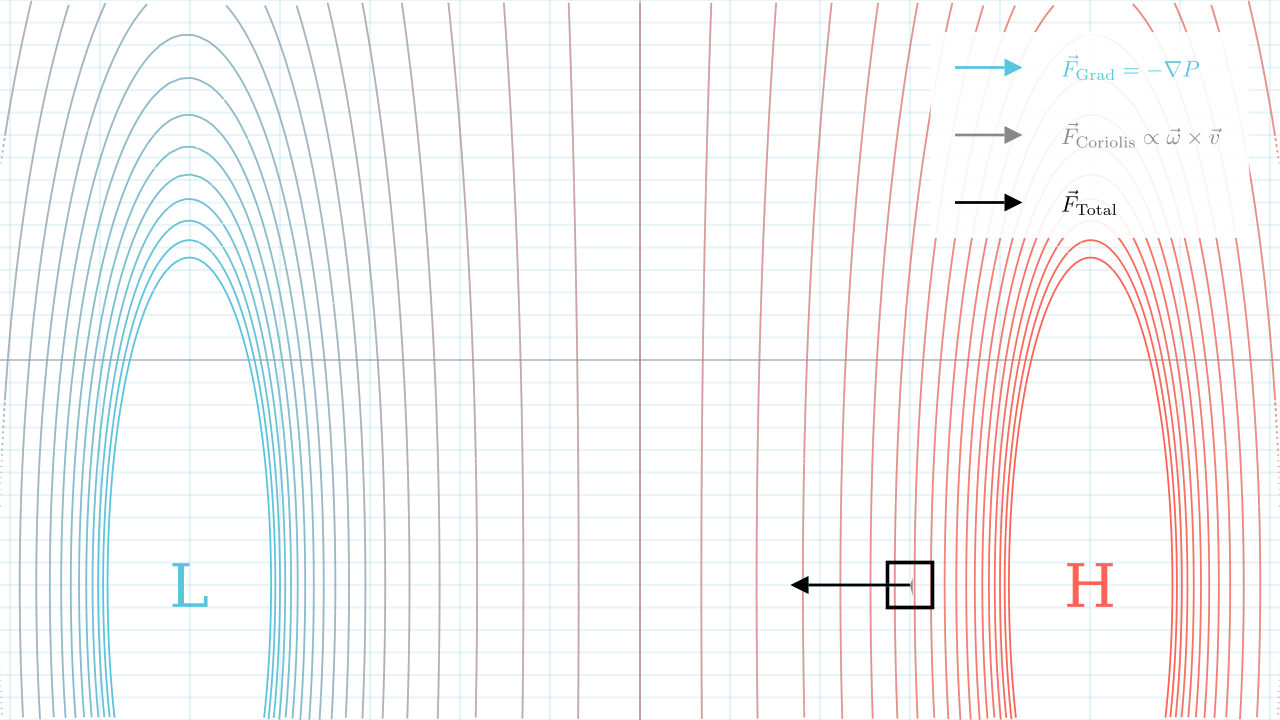

In [222]:
%%capture_video --path "animations/coriolis/coriolis_air.mp4"
%%manim -qm --fps 60 $video_scene

class coriolis_Scene(ThreeDScene):
    def construct(self):

        # design parameters
        self.camera.background_color = WHITE
        friction_arrow = False

        # physical parameters
        gamma = 0           # friction coefficient
        omega = -1           # angular velocity of the earth
        latitude = 45       # latitude in degrees
        params = (gamma, omega, latitude)

        # integration parameters
        t = 0               # initital time
        T_max = 100          # final time
        dt = 0.01            # stepsize

        # initial state of the air block
        x = 3.0
        y = -10
        v_x = 0
        v_y = 0
        air_state = np.array([x, y, v_x, v_y])
        

        pressure_field = PressureField(low_center = np.array([-5, -7, 0]), high_center = np.array([5, -7, 0]), low = -5, high = 5)
        self.add(pressure_field)

        arrow_legend = pressure_field.get_legend(center = np.array([5, 2.5, 0]), friction_arrow = friction_arrow)
        self.add(arrow_legend)

        isobars = pressure_field.get_isobars(isobaric_density = 36)
        self.add(isobars)

        air_block = pressure_field.get_air_block(air_state, params, friction_arrow = friction_arrow)
        self.add(air_block)


        # # numeric integration
        # list_of_states = [air_state]
        # ODE_Coriolis = pressure_field.get_ODE_Coriolis
        # while (t < T_max):
        #     air_state = rk4_step(t, dt, air_state, ODE_Coriolis, params)
        #     list_of_states.append(air_state)
        #     t += dt


        # # generating state iter from state list and connecting it to the air block
        # iter_of_states = iter(list_of_states)
        # air_block.iter = iter_of_states


        # # block updater
        # def block_updater(block):
        #     new_state = next(block.iter)
        #     new_block = pressure_field.get_air_block(new_state, params, friction_arrow = friction_arrow)
        #     block.become(new_block)

        
        # # time-evolution of the problem
        # time = ValueTracker(0)
        # air_block.add_updater(block_updater)
        # self.play(time.animate.set_value(10), rate_func= linear, run_time = 20)
